# 3 - Plot

## Load all results data and compute mean & std

In [80]:
import numpy as np
import os

PROJ_DIR = os.path.realpath(os.path.dirname(os.path.abspath('')))

FILENAME = os.path.join(PROJ_DIR, 'results', 'avila_0_results.npz')

keys = ['correct_pairings_inv', 'correct_pairings_basX', 'spearman_inv', 'spearman_basX', 'aucs_inv', 'aucs_basX', 'spearman_exceptional_inv', 'spearman_exceptional_basX']

result_dict = {}

for f in os.listdir(os.path.join(PROJ_DIR, 'results')):
    if f.endswith('_results.npz'):
        FILENAME = os.path.join(PROJ_DIR, 'results', f)
        with np.load(FILENAME) as data:
            for k in keys:
                d = np.expand_dims(data[k], axis=0)
                if k in result_dict:
                    result_dict[k] = np.vstack((result_dict[k], d))
                else:
                    result_dict[k] = d

for k in keys:
    result_dict[f'{k}_mean'] = np.nanmean(result_dict[k], axis=0)
    result_dict[f'{k}_std'] = np.nanstd(result_dict[k], axis=0)

# DEBUG
#print(result_dict['spearman_inv'])
#print(result_dict['spearman_inv_mean'])
#print(result_dict['spearman_basX'])
#print(result_dict['spearman_basX_mean'])

## Plot correct pairings

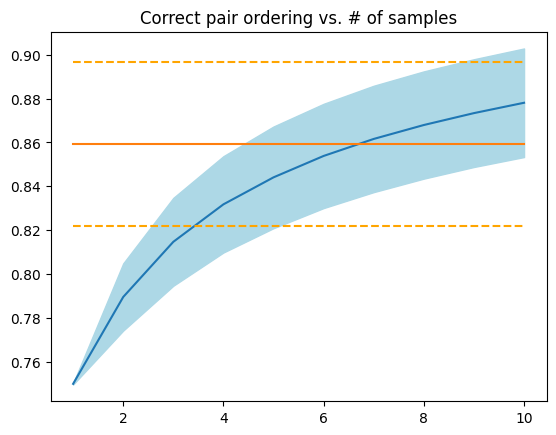

In [82]:
import matplotlib.pyplot as plt

plt.fill_between(range(1,11), result_dict['correct_pairings_basX_mean']+result_dict['correct_pairings_basX_std'], result_dict['correct_pairings_basX_mean']-result_dict['correct_pairings_basX_std'], color='lightblue')
plt.plot(range(1,11),result_dict['correct_pairings_basX_mean'])
plt.title('Correct pair ordering vs. # of samples')
plt.plot([1,10], [result_dict['correct_pairings_inv_mean']+result_dict['correct_pairings_inv_std'], result_dict['correct_pairings_inv_mean']+result_dict['correct_pairings_inv_std']], color='orange', linestyle = 'dashed')
plt.plot([1,10], [result_dict['correct_pairings_inv_mean']-result_dict['correct_pairings_inv_std'], result_dict['correct_pairings_inv_mean']-result_dict['correct_pairings_inv_std']], color='orange', linestyle = 'dashed')
plt.plot([1,10],[result_dict['correct_pairings_inv_mean'],result_dict['correct_pairings_inv_mean']])
plt.savefig(os.path.join(PROJ_DIR, 'results', 'plots', 'avila_correct_pairs.png'))
plt.show()

## Plot Spearman correlation

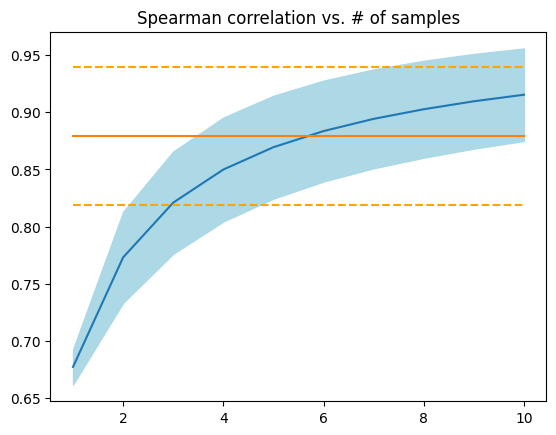

In [83]:
plt.fill_between(range(1,11), result_dict['spearman_basX_mean']+result_dict['spearman_basX_std'], result_dict['spearman_basX_mean']-result_dict['spearman_basX_std'], color='lightblue')
plt.plot(range(1,11),result_dict['spearman_basX_mean'])
plt.title('Spearman correlation vs. # of samples')
plt.plot([1,10], [result_dict['spearman_inv_mean']+result_dict['spearman_inv_std'], result_dict['spearman_inv_mean']+result_dict['spearman_inv_std']], color='orange', linestyle = 'dashed')
plt.plot([1,10], [result_dict['spearman_inv_mean']-result_dict['spearman_inv_std'], result_dict['spearman_inv_mean']-result_dict['spearman_inv_std']], color='orange', linestyle = 'dashed')
plt.plot([1,10],[result_dict['spearman_inv_mean'],result_dict['spearman_inv_mean']])
plt.savefig(os.path.join(PROJ_DIR, 'results', 'plots', 'avila_spearman.png'))
plt.show()

## Plot ability to detect exceptional rankings

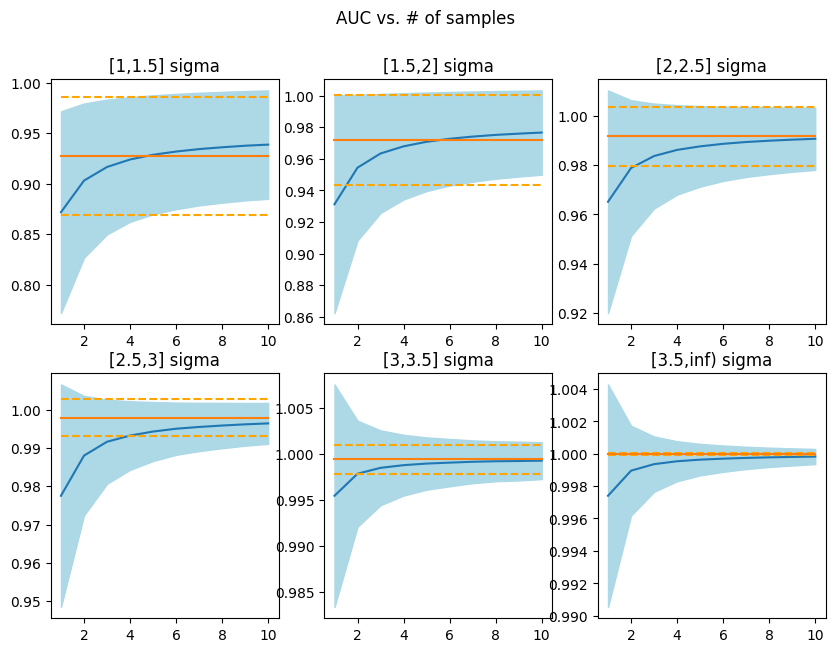

In [84]:
boundaries = [0.5, 1, 1.5, 2, 2.5, 3, 3.5]

fig, axes = plt.subplots(2, 3, figsize=(10, 7))
for i, ax in enumerate(axes.flat):
    ax.fill_between(range(1,11), result_dict['aucs_basX_mean'][:,i+1]+result_dict['aucs_basX_std'][:,i+1], result_dict['aucs_basX_mean'][:,i+1]-result_dict['aucs_basX_std'][:,i+1], color='lightblue')
    ax.plot(range(1,11),result_dict['aucs_basX_mean'][:,i+1])
    if i<len(boundaries)-2:
        ax.set_title(f'[{boundaries[i+1]},{boundaries[i+1+1]}] sigma')
    else:
        ax.set_title(f'[{boundaries[i+1]},inf) sigma')
    ax.plot([1,10], [result_dict['aucs_inv_mean'][i+1]+result_dict['aucs_inv_std'][i+1], result_dict['aucs_inv_mean'][i+1]+result_dict['aucs_inv_std'][i+1]], color='orange', linestyle = 'dashed')
    ax.plot([1,10], [result_dict['aucs_inv_mean'][i+1]-result_dict['aucs_inv_std'][i+1], result_dict['aucs_inv_mean'][i+1]-result_dict['aucs_inv_std'][i+1]], color='orange', linestyle = 'dashed')
    ax.plot([1,10],[result_dict['aucs_inv_mean'][i+1],result_dict['aucs_inv_mean'][i+1]])
plt.suptitle('AUC vs. # of samples')
plt.savefig(os.path.join(PROJ_DIR, 'results', 'plots', 'avila_auc_exceptional.png'))
plt.show()
plt.close(fig)

## Plot Spearman correlation for exceptional rankings

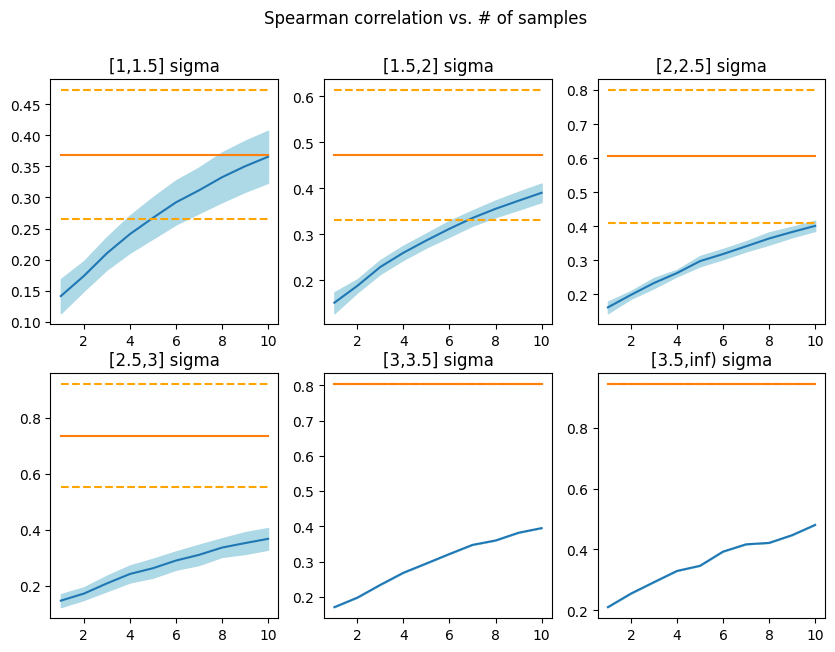

In [85]:
boundaries = [0.5, 1, 1.5, 2, 2.5, 3, 3.5]

fig, axes = plt.subplots(2, 3, figsize=(10, 7))
for i, ax in enumerate(axes.flat):
    ax.fill_between(range(1,11), result_dict['spearman_exceptional_basX_mean'][:,i+1]+result_dict['spearman_exceptional_basX_std'][:,i+1], result_dict['spearman_exceptional_basX_mean'][:,i+1]-result_dict['spearman_exceptional_basX_std'][:,i+1], color='lightblue')
    ax.plot(range(1,11),result_dict['spearman_exceptional_basX_mean'][:,i+1])
    if i<len(boundaries)-2:
        ax.set_title(f'[{boundaries[i+1]},{boundaries[i+1+1]}] sigma')
    else:
        ax.set_title(f'[{boundaries[i+1]},inf) sigma')
    ax.plot([1,10], [result_dict['spearman_exceptional_inv_mean'][i+1]+result_dict['spearman_exceptional_inv_std'][i+1], result_dict['spearman_exceptional_inv_mean'][i+1]+result_dict['spearman_exceptional_inv_std'][i+1]], color='orange', linestyle = 'dashed')
    ax.plot([1,10], [result_dict['spearman_exceptional_inv_mean'][i+1]-result_dict['spearman_exceptional_inv_std'][i+1], result_dict['spearman_exceptional_inv_mean'][i+1]-result_dict['spearman_exceptional_inv_std'][i+1]], color='orange', linestyle = 'dashed')
    ax.plot([1,10],[result_dict['spearman_exceptional_inv_mean'][i+1],result_dict['spearman_exceptional_inv_mean'][i+1]])
plt.suptitle('Spearman correlation vs. # of samples')
plt.savefig(os.path.join(PROJ_DIR, 'results', 'plots', 'avila_spearman_exceptional.png'))
plt.show()